In [1]:
import os
from os.path import join, sep
from glob import glob
from random import sample

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.layers import Rescaling, concatenate, Activation
from dotenv import find_dotenv, load_dotenv

In [3]:
from IPython.display import SVG
from keras.utils import model_to_dot
from keras.losses import MeanSquaredError, MeanAbsoluteError

In [4]:
from src.addons.images.load import load_image
from src.addons.data.pipeline import train_pipeline
from src.addons.watermark.submodels import to_luma_chroma_stack, to_rgb_stack, prepare_mark_stack, embedding_stack, extract_stack
from src.addons.watermark.losses import WatermarkLoss
from src.addons.data.augment import random_attacks
from src.addons.data.base import random_gaussian_blur

---

In [5]:
_ = load_dotenv(find_dotenv())

In [6]:
images_path = glob(join(os.environ.get("RAW_PATH"), "images") + sep + "*.jpg")
images_path = sample(images_path, 30)

In [7]:
train_set = train_pipeline(images_path, batch=5)

2023-12-24 00:58:32.272502: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-24 00:58:32.272530: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-24 00:58:32.272533: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-24 00:58:32.272566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-24 00:58:32.272582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


---

In [8]:
def get_embedding(image_dims, mark_dims):
    inputs_image = keras.Input(shape=image_dims)
    luma, chroma = to_luma_chroma_stack(inputs_image)

    input_mark = keras.Input(shape=mark_dims)
    output_mark = prepare_mark_stack(input_mark)

    luma = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(luma)
    embedding = concatenate([luma, output_mark], axis=-1)
    embedding =embedding_stack(embedding)
    
    outputs = to_rgb_stack([embedding, chroma])
    
    return keras.Model(inputs=[inputs_image, input_mark], outputs=outputs)

In [9]:
model_embedding = get_embedding((128, 128, 3), (8, 8, 1))

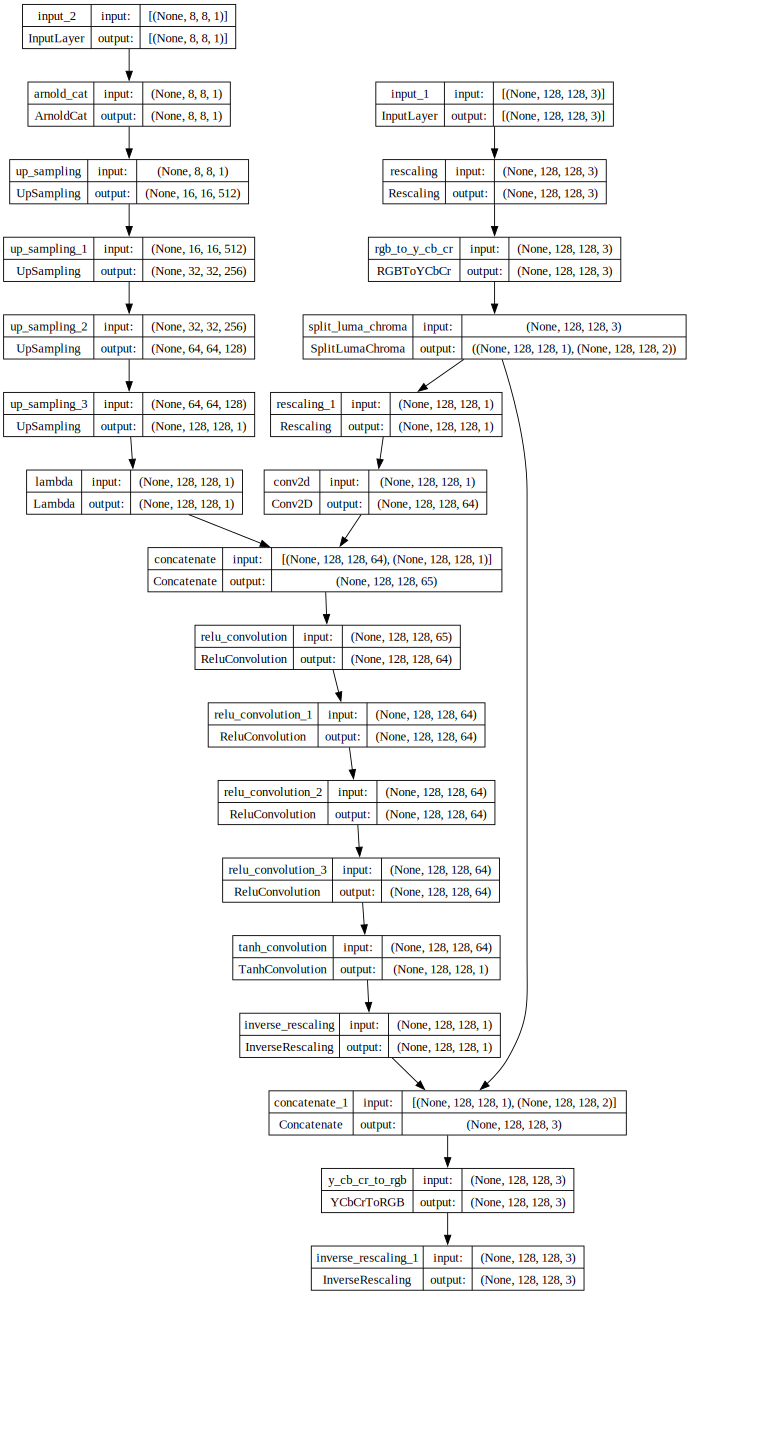

In [10]:
SVG(model_to_dot(model_embedding, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [11]:
def get_extract(image_dims):
    inputs_image = keras.Input(shape=image_dims)
    luma, _ = to_luma_chroma_stack(inputs_image)

    # ##: extraction network.
    outputs = extract_stack(luma)

    # ##: return model.
    return keras.Model(inputs=inputs_image, outputs=outputs)

In [12]:
model_extract = get_extract((128, 128, 3))

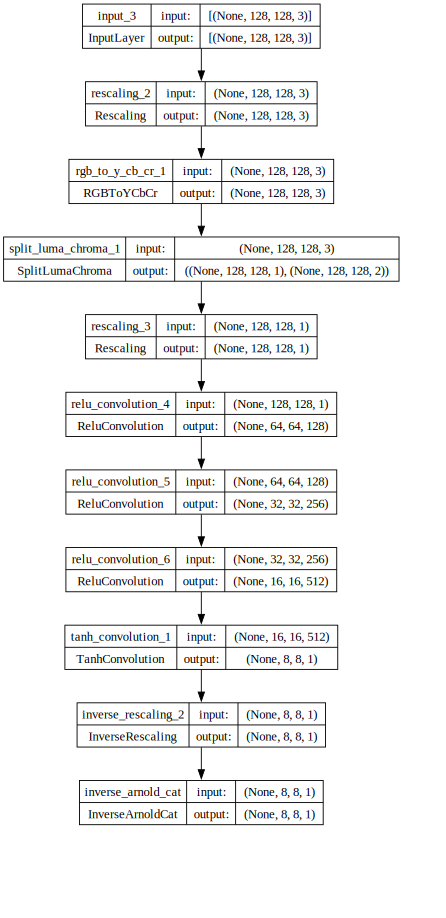

In [13]:
SVG(model_to_dot(model_extract, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

---

In [14]:
optimizer_embedding = keras.optimizers.Adam(1e-1)
optimizer_extract = keras.optimizers.Adam(1e-1)

In [15]:
for batch, (images, mark) in enumerate(train_set):
    with tf.GradientTape(persistent=True) as tape:
        outputs_image = model_embedding([images, mark], training=True)
        outputs_mark = model_extract(outputs_image, training=True)

        loss_embedding, loss_extract = WatermarkLoss()((images, mark), (outputs_image, outputs_mark))
    
    grads_embedding = tape.gradient(loss_embedding, model_embedding.trainable_variables)
    optimizer_embedding.apply_gradients(zip(grads_embedding, model_embedding.trainable_variables))
    
    grads_extract = tape.gradient(loss_extract, model_extract.trainable_variables)
    optimizer_extract.apply_gradients(zip(grads_extract, model_extract.trainable_variables))

    print(f"Lossese: {loss_embedding} - {loss_extract}")

Lossese: 8.316898345947266 - 10.31092643737793
Lossese: 11.871774673461914 - 9.89832878112793
Lossese: 10.446526527404785 - 10.41370964050293
Lossese: 11.700542449951172 - 9.935369491577148
Lossese: 11.808225631713867 - 10.812370300292969
Lossese: 15.694329261779785 - 9.500438690185547


In [16]:
for batch, (images, mark) in enumerate(train_set):
    with tf.GradientTape(persistent=True) as tape:
        outputs_image = model_embedding([images, mark], training=True)
        augment_image = random_attacks(outputs_image)
        outputs_mark = model_extract(augment_image, training=True)

        loss_embedding, loss_extract = WatermarkLoss()((images, mark), (outputs_image, outputs_mark))

    grads_emdedding = tape.gradient(loss_embedding, model_embedding.trainable_variables)
    optimizer_embedding.apply_gradients(zip(grads_emdedding, model_embedding.trainable_variables))
    
    grads_extract = tape.gradient(loss_extract, model_extract.trainable_variables)
    optimizer_extract.apply_gradients(zip(grads_extract, model_extract.trainable_variables))

    print(f"Lossese: {loss_embedding} - {loss_extract}")

Lossese: 4.792457103729248 - 9.4375
Lossese: 5.725353717803955 - 10.0
Lossese: 4.753095626831055 - 10.0625
Lossese: 4.312229633331299 - 10.0625
Lossese: 5.0631256103515625 - 10.8125
Lossese: 7.797415256500244 - 9.375
